<a href="https://colab.research.google.com/github/melkorCBA/movie-success-prediction/blob/main/Datamining_final_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
!pip install chart_studio
import chart_studio
chart_studio.tools.set_credentials_file(username='melkorCba', api_key='Fn4k6yKM6ebkQuHp6MoG')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [158]:


df = pd.read_csv('https://raw.githubusercontent.com/melkorCBA/movie-success-prediction/main/data/movies_metadata.csv')
df.head().transpose()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


In [159]:
# Data Wrangling 

# drop imdb id
df = df.drop(['imdb_id'], axis=1)

# drop original title
df[df['original_title'] != df['title']][['title', 'original_title']].head()
df = df.drop('original_title', axis=1)




In [160]:
# cleaning the revenue
df[df['revenue'] == 0].shape
df['revenue'] = df['revenue'].replace(0, np.nan)

In [161]:
# cleaning budget feature for uncleaned values
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape


(36576, 22)

In [162]:
# creating new features
# year - The year in which the movie was released
# return  - The ratio of revenue to budget.

df['return'] = df['revenue'] / df['budget']
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


In [163]:
# remove adult featue since close to 0 adult movies in this dataset
df['adult'].value_counts()
df = df.drop('adult', axis=1)



In [164]:
# removing null returns (The ratio of revenue to budget)
rgf = df[df['return'].notnull()]

In [165]:
#We have 5393 records in our training set. Let us take a look at the features we possess and remove the ones which are unnecessary.
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year'],
      dtype='object')

In [166]:
# will remove more unwanted features

rgf = rgf.drop(['id', 'overview', 'status', 'tagline', 'video', 'return', 'homepage', 'year', 'title', 'poster_path'], axis=1)

# since vote_average', 'vote_count are not availbe when movie is relased 
rgf = rgf.drop(['vote_average', 'vote_count'],  axis=1)

In [167]:
def get_month(x):
  month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
  try:
      return month_order[int(str(x).split('-')[1]) - 1]
  except:
      return np.nan

In [168]:
def get_day(x):
  day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
  try:
      year, month, day = (int(i) for i in x.split('-'))    
      answer = datetime.date(year, month, day).weekday()
      return day_order[answer]
  except:
      return np.nan

In [169]:
def feature_engineering(df):
  # belongs_to_collection will be turned into a Boolean variable. 1 indicates a movie is a part of collection whereas 0 indicates it is not.
  df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
  # genres will be converted into number of genres.
  df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval)
  df['genres'] = df['genres'].apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])
  df['genres'] = df['genres'].apply(lambda x: len(x))

  # production_companies will be replaced with just the number of production companies collaborating to make the movie.
  df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)  
  df['production_companies'] = df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
  df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
  # production_countries will be replaced with the number of countries the film was shot in.
  df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
  df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
  df['production_countries'] = df['production_countries'].apply(lambda x: len(x))

  # original_language will be replaced by a feature called is_foreign to denote if a particular film is in English or a Foreign Language.
  df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
  df = df.drop('original_language', axis=1)

  # spoken_languages wil be replaced by a feature called Spoken_only_english. indicates a only english is spoken in the movie whereas 0 indicates it is not.
  df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval)
  df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else [])
  df['Spoken_only_english'] = rgf['spoken_languages'].apply(lambda x: 1 if any('en' in lan for lan in x) and len(x) == 1 else 0) 
  df = df.drop(['spoken_languages'],  axis=1)

  # df = pd.get_dummies(df, prefix='is')
  df['runtime'] = df['runtime'].fillna(df['runtime'].mean())

  #date
  df['day'] = df['release_date'].apply(get_day)
  df['month'] = df['release_date'].apply(get_month)
  df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
  df = df.drop('day', axis=1)
  df['is_Holiday_Seasons'] = df['month'].apply(lambda x: 1 if x in ['May', 'Apr', 'Dec'] else 0)
  df = df.drop('month', axis=1)
  df = df.drop('release_date', axis=1)
  return df

In [170]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [171]:
# feature engineering tasks
X = feature_engineering(X)

In [172]:
#sperate traning data and test data
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [173]:
train_X.head(100)

,belongs_to_collection,budget,genres,popularity,production_companies,production_countries,runtime,is_english,Spoken_only_english,is_Friday,is_Holiday_Seasons
20447,1,92000000.0,2,12.4719,9,1,98.0,1,0,0,0
2374,1,7300.0,3,0.137676,0,1,87.0,1,0,1,0
17653,1,100000.0,2,8.95737,1,1,92.0,1,0,1,0
2772,1,8000000.0,4,4.6064,3,1,91.0,1,0,1,0
19862,1,33000000.0,3,7.85997,1,1,99.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11808,1,2380000.0,2,2.51464,4,1,101.0,1,0,0,0
4975,1,12000000.0,7,6.63136,2,1,93.0,1,0,1,0
35281,1,10000000.0,2,1.634827,1,1,87.0,1,0,1,0
2282,1,9000000.0,2,5.99705,1,1,93.0,1,0,0,0


In [174]:
# regression model

reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

#We get a Coefficient of Determination of 0.78 which is a pretty score for the basic model that we have built

0.6534601567854884

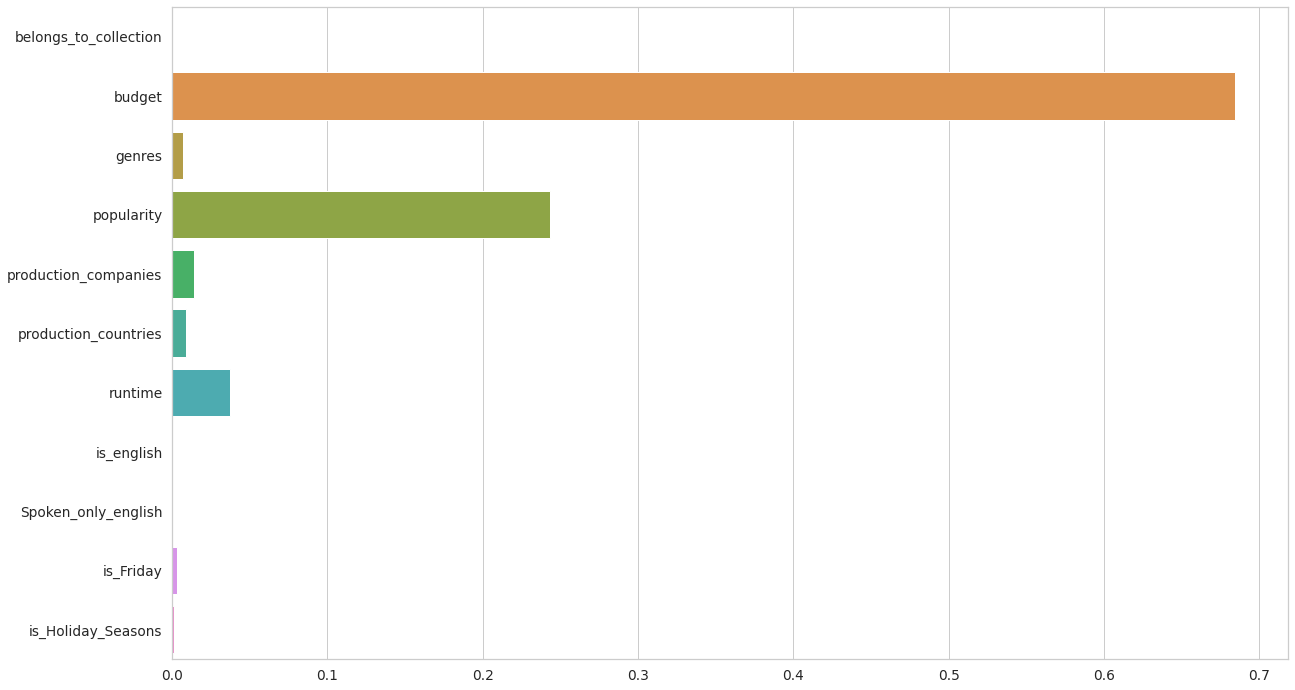

In [175]:
#let us plot the feature importances in the form of a bar plot to deduce which features were the most significant in our making predictions.
sns.set_style('whitegrid')
plt.figure(figsize=(20,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)


In [176]:
# Classification: Predicting Movie Sucesss
cls = df[df['return'].notnull()]
cls = cls.drop(['id', 'overview', 'status', 'tagline', 'revenue', 'poster_path'], axis=1)
cls['return'] = cls['return'].apply(lambda x: 1 if x >=1 else 0)
cls['belongs_to_collection'] = cls['belongs_to_collection'].fillna('').apply(lambda x: 0 if x == '' else 1)

In [177]:
def classification_engineering(df):
  # for genre in genres_train:
  # genres will be converted into number of genres.
  df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval)
  df['genres'] = df['genres'].apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])
  df['genres'] = df['genres'].apply(lambda x: len(x))
  df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
  df = df.drop('original_language', axis=1)
  df['production_companies'] = df['production_companies'].apply(lambda x: len(x))
  df['production_countries'] = df['production_countries'].apply(lambda x: len(x))

  
  # spoken_languages wil be replaced by a feature called Spoken_only_english. indicates a only english is spoken in the movie whereas 0 indicates it is not.
  df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval)
  df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else [])
  df['Spoken_only_english'] = rgf['spoken_languages'].apply(lambda x: 1 if any('en' in lan for lan in x) and len(x) == 1 else 0) 
  df = df.drop(['spoken_languages'],  axis=1)


  #date
  df['day'] = df['release_date'].apply(get_day)
  df['month'] = df['release_date'].apply(get_month)
  df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
  df = df.drop('day', axis=1)
  df['is_Holiday_Seasons'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'Dec', 'May'] else 0)
  df = df.drop('month', axis=1)
  df = df.drop('release_date', axis= 1)
  df = df.drop(['title'], axis=1)
  df = df.drop('homepage', axis=1)
  df = df.drop('video', axis=1)
  df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
  # since vote_average', 'vote_count are not availbe when movie is relased 
  df = df.drop(['vote_average', 'vote_count'],  axis=1)
  return df

In [178]:
cls = classification_engineering(cls)

In [179]:
train_X.head(10)

,belongs_to_collection,budget,genres,popularity,production_companies,production_countries,runtime,is_english,Spoken_only_english,is_Friday,is_Holiday_Seasons
20447,1,92000000.0,2,12.4719,9,1,98.0,1,0,0,0
2374,1,7300.0,3,0.137676,0,1,87.0,1,0,1,0
17653,1,100000.0,2,8.95737,1,1,92.0,1,0,1,0
2772,1,8000000.0,4,4.6064,3,1,91.0,1,0,1,0
19862,1,33000000.0,3,7.85997,1,1,99.0,1,0,0,0
11985,1,20000000.0,1,16.2051,2,1,113.0,1,0,1,0
1902,1,40000000.0,4,13.6899,3,1,108.0,1,0,0,0
16211,1,65000.0,3,2.79936,1,1,99.0,1,0,1,0
22415,1,5000000.0,2,8.89852,3,1,84.0,1,0,0,0
4596,1,1500000.0,2,14.2422,3,1,100.0,1,0,1,0


In [180]:
X, y = cls.drop('return', axis=1), cls['return']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

# Gradient Boosting Classifier has an accuracy of 80%. 

0.7563150074294205

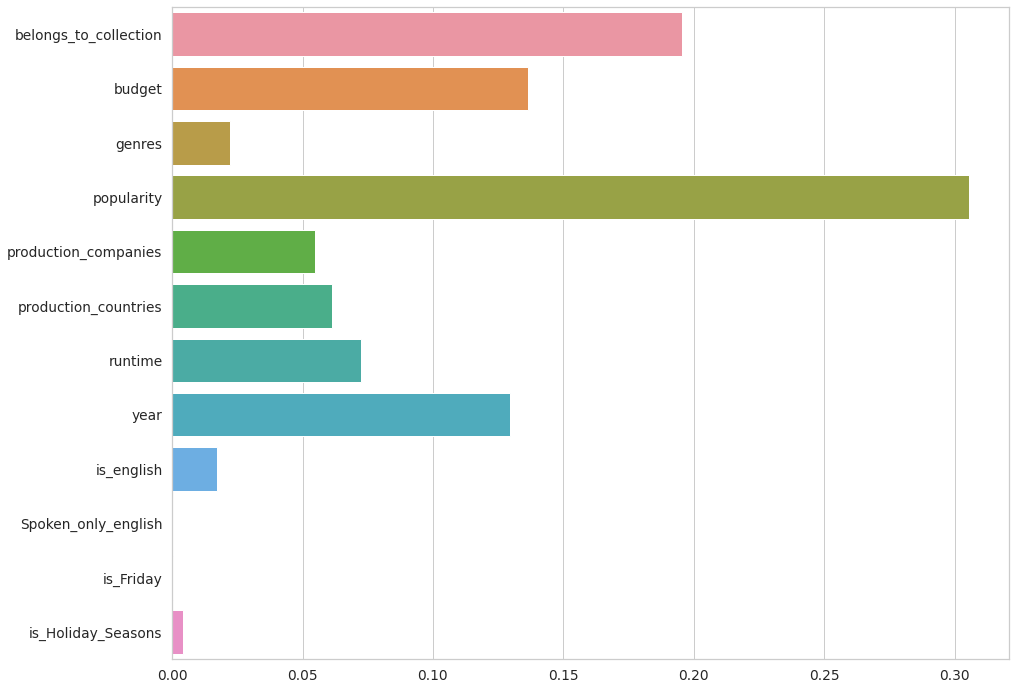

In [181]:
plt.figure(figsize=(15,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [197]:
test_X.shape

(1346, 12)

In [204]:
# testing the classifer 
import random

movie1 = [test_X.iloc[random.randint(0,1345)]]
movie2 = [test_X.iloc[random.randint(0,1345)]]

In [216]:
#movie1 prediction
yhat1 = clf.predict(movie1)
print('Predicted Class: %d' % yhat1[0])

Predicted Class: 1


In [217]:
#movie2 prediction
yhat2 = clf.predict(movie2)
print('Predicted Class: %d' % yhat2[0])

Predicted Class: 0
